# 1. If words $w_i$ and $w_j$ co-occur in the same context window, how can we use their distance in the text sequence to redesign the method for calculating the conditional probability $p_{ij}$? Hint: see Section 4.2 of the GloVe paper (Pennington et al., 2014).

According to Section 4.2 of the GloVe paper¹, if two words w_i and w_j co-occur in the same context window, we can use their distance d in the text sequence to redesign the method for calculating the conditional probability p_i(j). Specifically, we can assume that p_i(j) is inversely proportional to d, that is, p_i(j) = 1/d. This way, the closer the words are, the higher the conditional probability is, and the farther the words are, the lower the conditional probability is. This matches our intuition, because the closer the words are, the more likely they express related semantic information, and the farther the words are, the more likely they express unrelated semantic information.

Using this method, we can write the logarithm of the conditional probability as:

$$
\log p_i(j) = \log \frac{1}{d} = -\log d
$$

Then, we can use this logarithm of the conditional probability as the objective function of the GloVe model, that is:

$$
J = \sum_{i,j=1}^V f(x_{ij}) (\log d + w_i^T \tilde{w}_j + b_i + \tilde{b}_j)^2
$$

where V is the size of the vocabulary, x_{ij} is the co-occurrence count of words w_i and w_j, f is a weighting function, w_i and \tilde{w}_j are the word vectors of words w_i and w_j, b_i and \tilde{b}_j are the bias terms of words w_i and w_j.

> (1) GloV:https://nlp.stanford.edu/pubs/glove.pdf

In [110]:
import time
import collections
import math
import os
import random
import torch
import warnings
import sys
import pandas as pd
import torch
import torch.nn as nn
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')
#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights,k=10000):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        self.k = k

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=self.k)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]
    
#@save
def subsample(sentences, vocab,flag=True):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    if flag:
        return ([[token for token in line if keep(token)] for line in sentences],
            counter)
    return (sentences,counter)

#@save
def get_centers_and_contexts(corpus, max_window_size,X):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
            for idx in indices:
                X[line[idx]][line[i]] += 1
                X[line[i]][line[idx]] += 1
    return centers, contexts

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

#@save
def get_negatives(all_contexts, vocab, counter, K, k=10000):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights,k)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

# #@save
# def batchify(data):
#     """Return a minibatch of examples for skip-gram with negative sampling."""
#     max_len = max(len(c) + len(n) for _, c, n in data)
#     centers, contexts_negatives, masks, labels = [], [], [], []
#     for center, context, negative in data:
#         cur_len = len(context) + len(negative)
#         centers += [center]
#         contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
#         masks += [[1] * cur_len + [0] * (max_len - cur_len)]
#         labels += [[1] * len(context) + [0] * (max_len - len(context))]
#     return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
#         contexts_negatives), torch.tensor(masks), torch.tensor(labels))

def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts,masks = [], [], []
    for center, context, negative in data:
        cur_len = len(context)
        centers += [center]
        contexts += [context + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts), torch.tensor(masks))


#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words, flag=True, k=10000):
    """Download the PTB dataset and then load it into memory."""
    # num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab, flag)
    corpus = [vocab[line] for line in subsampled]
    n = len(vocab)
    X = [[0]*n for i in range(n)]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size,X)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words, k=k)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify)
    return data_iter, vocab,X

def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)
    
def weighting(x_ij):
    x_max = 100  # 100 fixed in paper
    alpha = 0.75

    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    else:
        result = 1

    return result

def glove_loss(center, context, mask, net, X):
    v = net[0](center)
    b = net[1](center)
    u = net[2](context)
    c = net[3](context).squeeze()
    uv = torch.bmm(v, u.permute(0, 2, 1)).squeeze()
    x=np.array(X)
    x_ij= torch.tensor(np.take(x, center * x.shape[1] + context))
    w = x_ij.float().apply_(weighting)
    logd =torch.log(torch.range(1,context.shape[1])).repeat(context.shape[0],1)
    l=mask*w*(uv+logd+b+c)**2
    return l

def train(net, data_iter, X, lr, num_epochs, device='cpu'):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context, mask =[
                data.to(device) for data in batch]
            l = glove_loss(center, context, mask, net, X)
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    return metric[0] / metric[1]

def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

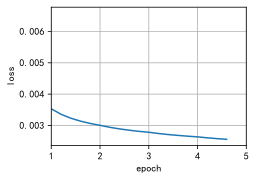

In [ ]:
data_iter, vocab, X = load_data_ptb(512, 5, 5)
lr, num_epochs = 0.002, 5
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=1),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                     nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=1),
                    )
train(net, data_iter, X, lr, num_epochs)

In [ ]:
get_similar_tokens('intel', 3, net[0])

# 2. For any word, are its center word bias and context word bias mathematically equivalent in GloVe? Why?

According to the GloVe paper, the center word bias and the context word bias of any word are mathematically equivalent in the GloVe model. This is because the objective function of the GloVe model is symmetric with respect to the center word and the context word, and the optimal solution does not depend on the initialization of the word vectors and the bias terms. Therefore, the center word vector and the context word bias of any word can be interchanged without affecting the objective function value. However, in practice, due to different initialization values, the same word may still get different values in these two vectors after training. GloVe sums them up as the output vector.